# Who's the biggest tax evader?

#### Imports:

In [1]:
import plotly.plotly as py
import pandas as pd
import pycountry
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

## 1. Data cleaning and preprocessing

In [2]:
# Load country codes
df_country_codes = pd.read_csv('data/countries_codes.csv', low_memory=False).set_index('COUNTRY')

In [3]:
# Load datasets
## Load panama papers datasets
pp_edges = pd.read_csv('data/panama_papers/panama_papers.edges.csv', low_memory=False)
pp_nodes_address = pd.read_csv('data/panama_papers/panama_papers.nodes.address.csv', low_memory=False)
pp_nodes_entity = pd.read_csv('data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
pp_nodes_intermediary = pd.read_csv('data/panama_papers/panama_papers.nodes.intermediary.csv', low_memory=False)
pp_nodes_officer = pd.read_csv('data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
## Load UN datasets
un_hdi_components_2014 = pd.read_csv('data/un/hdi_components.csv', low_memory=False)
un_gdp_per_capita = pd.read_csv('data/un/gdp_per_capita.csv', low_memory=False)
un_gdp_per_capita_ppp = pd.read_csv('data/un/gdp_per_capita_PPP.csv', low_memory=False)
## Load world bank datasets
wb_gini = pd.read_csv('data/world_bank/gini_index.csv', low_memory=False)
wb_income_share_20_per = pd.read_csv('data/world_bank/income_share_20_per.csv', low_memory=False)
wb_population_total = pd.read_csv('data/world_bank/population_total.csv', low_memory=False)

In [4]:
# Freedom index loading (TO BE ADDED)
freedom_index = pd.read_csv('data/human_freedom.csv', low_memory=False)
freedom_index = freedom_index.pivot(index='ISO_Code', columns='Year', values=['ECONOMIC FREEDOM (Score)','HUMAN FREEDOM (Score)'])
freedom_index = freedom_index.stack().groupby(level=0).last().reset_index()

In [64]:
countries_location = pd.read_csv('data/countries_latitude_longitude.csv')
countries_location = countries_location[['Alpha-3 code', 'Latitude (average)', 'Longitude (average)']]
countries_location = countries_location.rename(columns={'Alpha-3 code': 'Code', 'Latitude (average)': 'lat', 
                                                        'Longitude (average)': 'long'})

In [103]:
countries_location[countries_location['Code'] == 'VGB']

,Code,lat,long
235,VGB,18.5,-64.5


In [5]:
# We only consider statistics that date from 2000 onwards
years_to_drop = list(map(str, np.arange(1960, 2000)))
wb_gini = wb_gini.drop(columns=years_to_drop)
wb_income_share_20_per = wb_income_share_20_per.drop(columns=years_to_drop)

In [6]:
# We select the rightmost value (most recent) for each row
gini_values = wb_gini.stack().groupby(level=0).last().reindex(wb_gini.index)

# Only select valid values and label other values as NaN
wb_gini['Gini'] = pd.to_numeric(gini_values, errors='coerce')

# Only select relevant columns
wb_gini = wb_gini[['Country Name', 'Country Code', 'Gini']]

In [7]:
# We select the rightmost value (most recent) for each row
income_share_20_per_values = wb_income_share_20_per.stack().groupby(level=0).last().reindex(wb_income_share_20_per.index)

# Only select valid values and label other values as NaN
wb_income_share_20_per['Income Share'] = pd.to_numeric(income_share_20_per_values, errors='coerce')

# Only select relevant columns
wb_income_share_20_per = wb_income_share_20_per[['Country Name', 'Country Code', 'Income Share']]

In [8]:
# Join UN datasets with country codes DataFrame
un_hdi_components_2014 = un_hdi_components_2014.join(df_country_codes, on='Country')
un_gdp_per_capita = un_gdp_per_capita.join(df_country_codes, on='Country')
un_gdp_per_capita_ppp = un_gdp_per_capita_ppp.join(df_country_codes, on='Country')

In [9]:
# List of UN DataFrames
un_dfs = [un_hdi_components_2014, un_gdp_per_capita, un_gdp_per_capita_ppp]

# Define dictionary containing pairs (country name: ISO country code)
countries = dict()

for country in pycountry.countries:
    countries[country.name] = country.alpha_3  

for df in un_dfs:
    nan_values = df['CODE'].isna()
    input_countries = list(df[nan_values]['Country'].values)
        
    codes = []
    for country in input_countries:
        if country in countries:
            codes.append(countries.get(country))
        else:        
            accepted = []
            str_country = str(country)
            # check if string contains either common or official country name
            for p_country in pycountry.countries:
                if p_country.name in str_country or (hasattr(p_country, 'common_name') and p_country.common_name in str_country):
                    accepted.append(p_country.alpha_3)
            if len(accepted) == 1:
                codes.append(accepted[0])
            else:
                codes.append(None)

    df.loc[nan_values, 'CODE'] = codes
    # Remove rows that were not found
    df = df[df['CODE'].notnull()]

In [10]:
pp_references_country = pp_nodes_address.groupby(['country_codes', 'countries']).size().reset_index(name='counts')

In [11]:
wb_population_2014 = wb_population_total[['Country Code', '2014']]
occurrence_pop = pp_references_country.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')
occurrence_pop['counts_1000'] = 1000 * occurrence_pop['counts'] / occurrence_pop['2014']

## 2. Data analysis and observations

### 2.1 Panama Papers and population

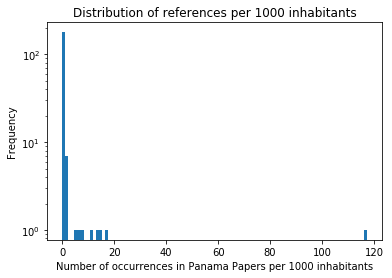

In [12]:
occurrence_pop['counts_1000'].plot.hist(title='Distribution of references per 1000 inhabitants', bins=100, logy=True)
plt.xlabel('Number of occurrences in Panama Papers per 1000 inhabitants')
plt.show()

In [13]:
pp_intermediary_country = pp_nodes_intermediary.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_intermediary_country = pp_intermediary_country.sort_values('counts', ascending=False)

We display the distribution using a map:

In [15]:
pp_intermediary_country.head(20)

,country_codes,countries,counts
91,HKG,Hong Kong,2202
75,GBR,United Kingdom,1367
28,CHE,Switzerland,1218
217,USA,United States,603
161,PAN,Panama,552
90,GTM,Guatemala,441
24,BRA,Brazil,399
132,LUX,Luxembourg,398
65,ECU,Ecuador,323
110,JEY;GBR,Jersey;United Kingdom,310


For the countries where the intermediaries come from, we can see that the top countries are

In [16]:
pp_intermediary_country_normalized = pp_intermediary_country.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')
pp_intermediary_country_normalized = pp_intermediary_country_normalized.merge(wb_income_share_20_per, left_on='country_codes', right_on='Country Code')
pp_intermediary_country_normalized = pp_intermediary_country_normalized.merge(freedom_index, left_on='country_codes', right_on='ISO_Code')
pp_intermediary_country_normalized['counts_normalized_population'] = pp_intermediary_country_normalized['counts'] / pp_intermediary_country_normalized['2014']
pp_intermediary_country_normalized['counts_normalized_income_share'] = pp_intermediary_country_normalized['counts'] * pp_intermediary_country_normalized['Income Share'] / 100
pp_intermediary_country_normalized['counts_normalized_economic_freedom'] = pp_intermediary_country_normalized['counts'] * pp_intermediary_country_normalized['ECONOMIC FREEDOM (Score)']
pp_intermediary_country_normalized['counts_normalized_human_freedom'] = pp_intermediary_country_normalized['counts'] * pp_intermediary_country_normalized['HUMAN FREEDOM (Score)']

In [17]:
data = [ dict(
        type = 'choropleth',
        locations = pp_intermediary_country_normalized['country_codes'],
        z = pp_intermediary_country_normalized['counts_normalized_population'],
        text = pp_intermediary_country_normalized['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Intermediaries in Panama Papers Normalized Population',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [18]:
pp_intermediary_country_normalized = pp_intermediary_country_normalized.sort_values('counts_normalized_population', ascending=False)
pp_intermediary_country_normalized[['countries','counts','counts_normalized_population']].head(10)

,countries,counts,counts_normalized_population
7,Luxembourg,398,0.000715
0,Hong Kong,2202,0.000305
19,Bahamas,106,0.000277
2,Switzerland,1218,0.000149
4,Panama,552,0.000141
33,Malta,43,0.000099
18,Cyprus,108,0.000094
9,Uruguay,296,0.000087
74,Seychelles,6,0.000066
30,Mauritius,55,0.000044


In [19]:
data = [ dict(
        type = 'choropleth',
        locations = pp_intermediary_country_normalized[pp_intermediary_country_normalized['Income Share'].notnull()]['country_codes'],
        z = pp_intermediary_country_normalized[pp_intermediary_country_normalized['Income Share'].notnull()]['counts_normalized_income_share'],
        text = pp_intermediary_country_normalized[pp_intermediary_country_normalized['Income Share'].notnull()]['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Intermediaries in Panama Papers Normalized Income Share',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [59]:
pp_intermediary_country_normalized = pp_intermediary_country_normalized.sort_values('counts_normalized_income_share', ascending=False)
pp_intermediary_country_normalized[['countries','counts','counts_normalized_income_share']].head(10)

,countries,counts,counts_normalized_income_share
1,United Kingdom,1367,555.002
2,Switzerland,1218,489.636
4,Panama,552,302.496
3,United States,603,282.807
5,Guatemala,441,236.376
6,Brazil,399,223.839
7,Luxembourg,398,163.180
8,Ecuador,323,163.115
9,Uruguay,296,135.864
11,Colombia,227,126.439


In [20]:
data = [ dict(
        type = 'choropleth',
        locations = pp_intermediary_country_normalized[pp_intermediary_country_normalized['counts_normalized_economic_freedom'].notnull()]['country_codes'],
        z = pp_intermediary_country_normalized[pp_intermediary_country_normalized['counts_normalized_economic_freedom'].notnull()]['counts_normalized_economic_freedom'],
        text = pp_intermediary_country_normalized[pp_intermediary_country_normalized['counts_normalized_economic_freedom'].notnull()]['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Intermediaries in Panama Papers Normalized Economic Freedom',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [21]:
pp_intermediary_country_normalized = pp_intermediary_country_normalized.sort_values('counts_normalized_economic_freedom', ascending=False)
pp_intermediary_country_normalized[['countries','counts','counts_normalized_economic_freedom']].head(10)

,countries,counts,counts_normalized_economic_freedom
0,Hong Kong,2202,19751.94
1,United Kingdom,1367,11004.35
2,Switzerland,1218,10279.92
3,United States,603,4787.82
4,Panama,552,4189.68
5,Guatemala,441,3391.29
7,Luxembourg,398,3036.74
6,Brazil,399,2294.25
9,Uruguay,296,2119.36
8,Ecuador,323,1899.24


In [22]:
data = [ dict(
        type = 'choropleth',
        locations = pp_intermediary_country_normalized[pp_intermediary_country_normalized['counts_normalized_human_freedom'].notnull()]['country_codes'],
        z = pp_intermediary_country_normalized[pp_intermediary_country_normalized['counts_normalized_human_freedom'].notnull()]['counts_normalized_human_freedom'],
        text = pp_intermediary_country_normalized[pp_intermediary_country_normalized['counts_normalized_human_freedom'].notnull()]['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Intermediaries in Panama Papers Normalized Human Freedom',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [23]:
pp_intermediary_country_normalized = pp_intermediary_country_normalized.sort_values('counts_normalized_human_freedom', ascending=False)
pp_intermediary_country_normalized[['countries','counts','counts_normalized_human_freedom']].head(10)

,countries,counts,counts_normalized_human_freedom
0,Hong Kong,2202,19553.76
1,United Kingdom,1367,11687.85
2,Switzerland,1218,10828.02
3,United States,603,5059.17
4,Panama,552,4222.80
7,Luxembourg,398,3375.04
5,Guatemala,441,3135.51
6,Brazil,399,2521.68
9,Uruguay,296,2305.84
8,Ecuador,323,2157.64


### Officers

In [24]:
pp_officer_country = pp_nodes_officer.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_officer_country = pp_officer_country.sort_values('counts', ascending=False)

In [67]:
data = [ dict(
        type = 'choropleth',
        locations = pp_officer_country['country_codes'],
        z = pp_officer_country['counts'],
        text = pp_officer_country['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Officer in Panama Papers',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [26]:
pp_officer_country.head(10)

,country_codes,countries,counts
33,CHN,China,24635
75,HKG,Hong Kong,13362
192,VGB,British Virgin Islands,11231
90,JEY,Jersey,6892
142,PAN,Panama,5069
61,GBR,United Kingdom,4914
31,CHE,Switzerland,4268
154,RUS,Russia,4119
183,TWN,Taiwan,3692
188,USA,United States,3612


In [27]:
pp_officer_country_normalized = pp_officer_country.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')
pp_officer_country_normalized = pp_officer_country_normalized.merge(wb_income_share_20_per, left_on='country_codes', right_on='Country Code')
pp_officer_country_normalized = pp_officer_country_normalized.merge(freedom_index, left_on='country_codes', right_on='ISO_Code')
pp_officer_country_normalized['counts_normalized_population'] = pp_officer_country_normalized['counts'] / pp_officer_country_normalized['2014']
pp_officer_country_normalized['counts_normalized_income_share'] = pp_officer_country_normalized['counts'] * pp_officer_country_normalized['Income Share'] / 100
pp_officer_country_normalized['counts_normalized_economic_freedom'] = pp_officer_country_normalized['counts'] * pp_officer_country_normalized['ECONOMIC FREEDOM (Score)']
pp_officer_country_normalized['counts_normalized_human_freedom'] = pp_officer_country_normalized['counts'] * pp_officer_country_normalized['HUMAN FREEDOM (Score)']

In [28]:
data = [ dict(
        type = 'choropleth',
        locations = pp_officer_country_normalized['country_codes'],
        z = pp_officer_country_normalized['counts_normalized_population'],
        text = pp_officer_country_normalized['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Officer in Panama Papers Normalized Population',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [29]:
pp_officer_country_normalized = pp_officer_country_normalized.sort_values('counts_normalized_population', ascending=False)
pp_officer_country_normalized[['countries', 'counts', 'counts_normalized_population']].head(20)

,countries,counts,counts_normalized_population
14,Seychelles,1706,0.018674
17,Bahamas,1442,0.003773
13,Luxembourg,1745,0.003137
8,Cyprus,2684,0.002329
1,Hong Kong,13362,0.001848
35,Belize,519,0.001476
2,Panama,5069,0.001298
18,Mauritius,1306,0.001036
43,Malta,325,0.000748
57,Iceland,211,0.000644


In [30]:
data = [ dict(
        type = 'choropleth',
        locations = pp_officer_country_normalized[pp_officer_country_normalized['Income Share'].notnull()]['country_codes'],
        z = pp_officer_country_normalized[pp_officer_country_normalized['Income Share'].notnull()]['counts_normalized_income_share'],
        text = pp_officer_country_normalized[pp_officer_country_normalized['Income Share'].notnull()]['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Officer in Panama Papers Normalized Income Share',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [31]:
pp_officer_country_normalized = pp_officer_country_normalized.sort_values('counts_normalized_income_share', ascending=False)
pp_officer_country_normalized[['countries', 'counts', 'counts_normalized_income_share']].head(20)

,countries,counts,counts_normalized_income_share
0,China,24635,11800.165
2,Panama,5069,2777.812
3,United Kingdom,4914,1995.084
5,Russia,4119,1865.907
4,Switzerland,4268,1715.736
6,United States,3612,1694.028
12,South Africa,1917,1307.394
8,Cyprus,2684,1129.964
10,Brazil,2008,1126.488
11,Uruguay,2003,919.377


In [58]:
data = [ dict(
        type = 'choropleth',
        locations = pp_officer_country_normalized[pp_officer_country_normalized['counts_normalized_economic_freedom'].notnull()]['country_codes'],
        z = pp_officer_country_normalized[pp_officer_country_normalized['counts_normalized_economic_freedom'].notnull()]['counts_normalized_economic_freedom'],
        text = pp_officer_country_normalized[pp_officer_country_normalized['counts_normalized_economic_freedom'].notnull()]['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Officer in Panama Papers Normalized Economic Freedom',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [54]:
pp_officer_country_normalized = pp_officer_country_normalized.sort_values('counts_normalized_economic_freedom', ascending=False)
pp_officer_country_normalized[['countries','counts','counts_normalized_economic_freedom']].head(10)

,countries,counts,counts_normalized_economic_freedom
0,China,24635,157664.00
1,Hong Kong,13362,119857.14
3,United Kingdom,4914,39557.70
2,Panama,5069,38473.71
4,Switzerland,4268,36021.92
6,United States,3612,28679.28
5,Russia,4119,27185.40
7,United Arab Emirates,2990,22425.00
8,Cyprus,2684,20908.36
9,Singapore,2273,20025.13


In [57]:
data = [ dict(
        type = 'choropleth',
        locations = pp_officer_country_normalized[pp_officer_country_normalized['counts_normalized_human_freedom'].notnull()]['country_codes'],
        z = pp_officer_country_normalized[pp_officer_country_normalized['counts_normalized_human_freedom'].notnull()]['counts_normalized_human_freedom'],
        text = pp_officer_country_normalized[pp_officer_country_normalized['counts_normalized_human_freedom'].notnull()]['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Officer in Panama Papers Normalized Human Freedom',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [56]:
pp_officer_country_normalized = pp_officer_country_normalized.sort_values('counts_normalized_human_freedom', ascending=False)
pp_officer_country_normalized[['countries','counts','counts_normalized_human_freedom']].head(10)

,countries,counts,counts_normalized_human_freedom
0,China,24635,148056.35
1,Hong Kong,13362,118654.56
3,United Kingdom,4914,42014.70
2,Panama,5069,38777.85
4,Switzerland,4268,37942.52
6,United States,3612,30304.68
5,Russia,4119,25167.09
8,Cyprus,2684,22035.64
7,United Arab Emirates,2990,19106.10
9,Singapore,2273,18956.82


### Entities

In [32]:
pp_entity_country = pp_nodes_entity.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_entity_country = pp_entity_country.sort_values('counts', ascending=False)

In [33]:
data = [ dict(
        type = 'choropleth',
        locations = pp_entity_country['country_codes'],
        z = pp_entity_country['counts'],
        text = pp_entity_country['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Entity in Panama Papers',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [34]:
pp_entity_country.head(15)

,country_codes,countries,counts
59,HKG,Hong Kong,37911
27,CHE,Switzerland,37911
114,PAN,Panama,15811
73,JEY,Jersey,14331
89,LUX,Luxembourg,10840
51,GBR,United Kingdom,9619
53,GGY,Guernsey,7327
5,ARE,United Arab Emirates,7269
16,BHS,Bahamas,4984
145,URY,Uruguay,4906


In [35]:
pp_entity_country_normalized = pp_entity_country.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')
pp_entity_country_normalized = pp_entity_country_normalized.merge(wb_income_share_20_per, left_on='country_codes', right_on='Country Code')
pp_entity_country_normalized['counts_normalized_population'] = pp_entity_country_normalized['counts'] / pp_entity_country_normalized['2014']
pp_entity_country_normalized['counts_normalized_income_share'] = pp_entity_country_normalized['counts'] * pp_entity_country_normalized['Income Share'] / 100

In [36]:
data = [ dict(
        type = 'choropleth',
        locations = pp_entity_country_normalized['country_codes'],
        z = pp_entity_country_normalized['counts_normalized_population'],
        text = pp_entity_country_normalized['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Entity in Panama Papers Normalized Population',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=50,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [37]:
pp_entity_country_normalized = pp_entity_country_normalized.sort_values('counts_normalized_population', ascending=False)
pp_entity_country_normalized[['countries','counts','counts_normalized_population']].head(20)

,countries,counts,counts_normalized_population
13,Monaco,3168,0.083080
16,Gibraltar,2039,0.059904
8,Isle of Man,4892,0.059232
15,Liechtenstein,2066,0.055647
27,British Virgin Islands,1107,0.037414
3,Luxembourg,10840,0.019485
6,Bahamas,4984,0.013041
19,Samoa,1613,0.008388
32,Seychelles,683,0.007476
35,Andorra,489,0.006172


In [38]:
data = [ dict(
        type = 'choropleth',
        locations = pp_entity_country_normalized[pp_entity_country_normalized['Income Share'].notnull()]['country_codes'],
        z = pp_entity_country_normalized[pp_entity_country_normalized['Income Share'].notnull()]['counts_normalized_income_share'],
        text = pp_entity_country_normalized[pp_entity_country_normalized['Income Share'].notnull()]['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Entity in Panama Papers Normalized Income Share',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=50,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [39]:
pp_entity_country_normalized = pp_entity_country_normalized.sort_values('counts_normalized_income_share', ascending=False)
pp_entity_country_normalized[['countries','counts','counts_normalized_income_share']].head(20)

,countries,counts,counts_normalized_income_share
1,Switzerland,37911,15240.222
2,Panama,15811,8664.428
3,Luxembourg,10840,4444.400
4,United Kingdom,9619,3905.314
7,Uruguay,4906,2251.854
9,Russia,4197,1901.241
12,China,3213,1539.027
11,Cyprus,3613,1521.073
14,United States,3066,1437.954
17,Colombia,1854,1032.678


### Addresses

In [40]:
pp_address_country = pp_nodes_address.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_address_country = pp_address_country.sort_values('counts', ascending=False)

In [41]:
data = [ dict(
        type = 'choropleth',
        locations = pp_address_country['country_codes'],
        z = pp_address_country['counts'],
        text = pp_address_country['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
    
        geo = 'geo2'
      ) ]

layout = dict(
    title = 'Address in Panama Papers',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution= 1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [42]:
pp_address_country.head(10)

,country_codes,countries,counts
33,CHN,China,20267
75,HKG,Hong Kong,9147
61,GBR,United Kingdom,3996
193,VGB,British Virgin Islands,3467
155,RUS,Russia,3346
189,USA,United States,3094
90,JEY,Jersey,2852
31,CHE,Switzerland,2827
142,PAN,Panama,2508
184,TWN,Taiwan,2249


In [43]:
pp_address_country_normalized = pp_address_country.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')
pp_address_country_normalized = pp_address_country_normalized.merge(wb_income_share_20_per, left_on='country_codes', right_on='Country Code')
pp_address_country_normalized['counts_normalized_population'] = pp_address_country_normalized['counts'] / pp_address_country_normalized['2014']
pp_address_country_normalized['counts_normalized_income_share'] = pp_address_country_normalized['counts'] * pp_address_country_normalized['Income Share'] / 100

In [44]:
data = [ dict(
        type = 'choropleth',
        locations = pp_address_country_normalized['country_codes'],
        z = pp_address_country_normalized['counts_normalized_population'],
        text = pp_address_country_normalized['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Addresses in Panama Papers Normalized Population',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [45]:
pp_address_country_normalized = pp_address_country_normalized.sort_values('counts_normalized_population', ascending=False)
pp_address_country_normalized[['countries','counts','counts_normalized_population']].head(20)

,countries,counts,counts_normalized_population
3,British Virgin Islands,3467,0.117176
28,Liechtenstein,635,0.017103
31,Monaco,538,0.014109
14,Isle of Man,1144,0.013852
37,Gibraltar,393,0.011546
21,Seychelles,733,0.008023
38,Cayman Islands,389,0.006574
43,Saint Kitts and Nevis,292,0.005434
66,Bermuda,150,0.002303
18,Bahamas,842,0.002203


In [95]:
data = [ dict(
        type = 'choropleth',
        locations = pp_address_country_normalized[pp_address_country_normalized['Income Share'].notnull()]['country_codes'],
        z = pp_address_country_normalized[pp_address_country_normalized['Income Share'].notnull()]['counts_normalized_income_share'],
        text = pp_address_country_normalized[pp_address_country_normalized['Income Share'].notnull()]['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'Addresses in Panama Papers Normalized Income Share',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=50,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [47]:
pp_address_country_normalized = pp_address_country_normalized.sort_values('counts_normalized_income_share', ascending=False)
pp_address_country_normalized[['countries','counts','counts_normalized_income_share']].head(20)

,countries,counts,counts_normalized_income_share
0,China,20267,9707.893
2,United Kingdom,3996,1622.376
4,Russia,3346,1515.738
5,United States,3094,1451.086
7,Panama,2508,1374.384
6,Switzerland,2827,1136.454
12,South Africa,1370,934.340
11,Brazil,1395,782.595
10,Cyprus,1489,626.869
13,Malaysia,1216,575.168


### Folium

In [48]:
min_count = pp_intermediary_country['counts'].min()
max_count = pp_intermediary_country['counts'].max()

In [49]:
def firstOrDefault(values, default):
    if values is None or len(values) == 0:
        return default
    return values[0]

In [50]:
import folium

linear = folium.LinearColormap(['green','yellow','orange','red'], vmin=min_count, vmax=max_count)


country_geo = 'data/countries.geojson'

map_folium = folium.Map(location=[100, 0], zoom_start=1.5)
folium.GeoJson(
    country_geo,
    style_function=lambda feature: {
        'fillColor': linear(firstOrDefault(
            pp_intermediary_country[pp_intermediary_country['country_codes'] == feature['properties']['ISO_A3']]['counts'].values, 0)),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '1, 1'
        }
    ).add_to(map_folium)

map_folium.add_child(linear)
"""
map_folium.choropleth(geo_data=country_geo, 
                    data=pp_intermediary_country,
                    columns=['country_codes', 'counts'],
                    key_on='properties.ISO_A3',
                    fill_color='YlGnBu',
                    fill_opacity=0.7, line_opacity=0.2)
"""

map_folium.save('plot_data.html')


from IPython.display import HTML
HTML('<iframe src=plot_data.html width=700 height=450></iframe>')

KeyError: 'ISO_A3'

In [92]:
test_points.head(100)

,country_codes,countries,counts,Code,lat,long
0,HKG,Hong Kong,2202,HKG,22.2500,114.1667
1,GBR,United Kingdom,1367,GBR,54.0000,-2.0000
2,CHE,Switzerland,1218,CHE,47.0000,8.0000
3,USA,United States,603,USA,38.0000,-97.0000
4,PAN,Panama,552,PAN,9.0000,-80.0000
5,GTM,Guatemala,441,GTM,15.5000,-90.2500
6,BRA,Brazil,399,BRA,-10.0000,-55.0000
7,LUX,Luxembourg,398,LUX,49.7500,6.1667
8,ECU,Ecuador,323,ECU,-2.0000,-77.5000
9,URY,Uruguay,296,URY,-33.0000,-56.0000


In [100]:
test_points = pp_intermediary_country.merge(countries_location,left_on='country_codes',right_on='Code')

colors = ['rgb(239,243,255)','rgb(189,215,231)','rgb(107,174,214)','rgb(33,113,181)']


data = [ dict(
        type = 'choropleth',
        locations = test_points['country_codes'],
        z = test_points['counts'],
        text = test_points['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      )
      ]

layout = dict(
    title = 'Intermediaries in Panama Papers',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=1,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)

cases = [   
        go.Scattergeo(
            lon = test_points['long'],
            lat = test_points['lat'],
            text = test_points['countries'],
            showlegend = False,
            geo = 'geo2',
            marker = dict(
                size = test_points['counts']/20,
                color = colors[i-6],
                line = dict(width = 0)
        ),
        )]

fig = dict( data=cases+data, layout=layout)

iplot( fig, validate=False)

## 3. Milestone 3

We can see from the tables that most of the countries involved in the Panama Papers affair are small islands, which unfortunately are not displayed by the `Plotly` library. For the next milestone, we will fix that issue either by finding a solution that still works with `Plotly` or by using a different library, such as `folium`.

So far, we have made insightful observations that match the reports found in the media, particularly about which countries were most involved in this affair.

For the next milestone, we will further investigate the links between the countries, and try to understand the correlation of socio-economic factors with the locations of entities, officers and intermediaries involved in Panama Papers. More specifically, we intend to:
- Find which socio-economic factors are correlated with the results we found so far, and how they are correlated
- Display the links between the countries using a graph similar to the one found [here](https://plot.ly/python/lines-on-maps/)
- Fix issues with certain countries (particularly small islands) not being displayed in the graph
-

In [ ]:
pp_edges_parsed = pp_edges[['START_ID', 'TYPE', 'END_ID']]

In [ ]:
pp_nodes_intermediary_parsed = pp_nodes_intermediary[['node_id', 'country_codes', 'countries']]
pp_nodes_entity_parsed = pp_nodes_entity[['node_id', 'country_codes', 'countries']]
pp_nodes_officer_parsed = pp_nodes_officer[['node_id', 'country_codes', 'countries']]

In [ ]:
pp_nodes = pp_nodes_entity_parsed.append(pp_nodes_intermediary_parsed).append(pp_nodes_officer_parsed)
pp_nodes = pp_nodes.dropna()

In [ ]:
pp_edges_countries = pp_nodes.merge(pp_edges_parsed, left_on='node_id', right_on='START_ID')
pp_edges_countries = pp_edges_countries.rename(columns={'node_id': 'id_origin', 'country_codes': 'cc_origin', 
                                                        'countries': 'c_origin'})
pp_edges_countries = pp_edges_countries.merge(pp_nodes, left_on='END_ID', right_on='node_id')
pp_edges_countries = pp_edges_countries.rename(columns={'node_id': 'id_dest', 'country_codes': 'cc_dest', 
                                                        'countries': 'c_dest'})
pp_edges_countries = pp_edges_countries.drop(columns=['id_origin', 'id_dest'])